In [5]:
!pip install mlflow
!pip install requests
!pip install tabulate
!pip install "colorama >= 0.3.8"
!pip install future
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o
!pip install h2o-wave

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html


In [1]:
import mlflow
import mlflow.sklearn

#mlflow.set_tracking_uri("file:///mlruns")  # Set this to your MLflow server or leave as default for local tracking


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
DATA_PATH = Path() / "../data"
#DATA_PATH = Path('/content/gdrive/My Drive/Colab Notebooks/VC_data_Cleaning_With_LLM/data')
DATA_PATH.mkdir(parents=True,exist_ok=True)

def load_csv(filename, data_path=DATA_PATH,encoding='ISO-8859-1'):
    csv_path = data_path / filename
    return pd.read_csv(csv_path,encoding=encoding)

def save_csv(data, filename, data_path=DATA_PATH,encoding='ISO-8859-1'):
    csv_path = data_path / filename
    data.to_csv(csv_path, index=False,encoding='ISO-8859-1')

def load_excel(filename, data_path=DATA_PATH):
    csv_path = data_path / filename
    return pd.read_excel(csv_path)

PLOT_PATH = Path() / "../plot"
#PLOT_PATH = Path('/content/gdrive/My Drive/Colab Notebooks/VC_data_Cleaning_With_LLM/plot')
PLOT_PATH.mkdir(parents=True,exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300, transparent=True):
    path = PLOT_PATH / f"{fig_id}.{fig_extension}"
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution, transparent=transparent)

RESULT_PATH = Path() / "../result"
#PLOT_PATH = Path('/content/gdrive/My Drive/Colab Notebooks/VC_data_Cleaning_With_LLM/plot')
RESULT_PATH.mkdir(parents=True,exist_ok=True)
def save_result(data, filename, data_path=RESULT_PATH):
    csv_path = data_path / filename
    data.to_csv(csv_path, index=False, encoding='utf-8-sig')

def save_excel(data, filename, data_path=RESULT_PATH):
    csv_path = data_path / filename
    data.to_excel(csv_path, index=False)

import h2o

# Define the default path where models will be saved
MODEL_PATH = Path() / "../models"
MODEL_PATH.mkdir(parents=True, exist_ok=True)

def save_h2o_model(model, filename, model_path=RESULT_PATH):
    full_path = model_path / filename
    full_path.parent.mkdir(parents=True, exist_ok=True)
    saved_model_path = h2o.save_model(model=model, path=str(full_path.parent), force=True)
    print(f"Model saved to: {saved_model_path}")
    return saved_model_path


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,3 hours 29 mins
H2O_cluster_timezone:,America/Toronto
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,1 month and 10 days
H2O_cluster_name:,H2O_from_python_TYS_gefzhk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.662 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
18:45:08.78: Project: AutoML_8_20240423_184508
18:45:08.78: 5-fold cross-validation will be used.
18:45:08.79: Setting stopping tolerance adaptively based on the training frame: 0.028676966733820218
18:45:08.79: Build control seed: 1
18:45:08.79: training frame: Frame key: AutoML_8_20240423_184508_training_py_2_sid_b16b    cols: 22    rows: 1216  chunks: 1    size: 208582  checksum: -140458100710306879
18:45:08.79: validation frame: NULL
18:45:08.79: leaderboard frame: NULL
18:45:08.79: blending frame: NULL
18:45:08.79: response column: Order Item Quantity
18:45:08.80: fold column: null
18:45:08.80: weights column: null
18:45:08.81: AutoML: XGBoost is not available; skipping it.
18:45:08.81: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (7g, 30w)]}, {GLM : [def_1 (1g, 10w)]}, {DRF : [def_1 (2g, 10w), XR

c:\Users\TYS\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Model saved to: C:\Users\TYS\Documents\study\Master\INSY695 Enterprise Data Science II\Final Project\DataCo_Supply_Chain\result\DeepLearning_1_AutoML_8_20240423_184508


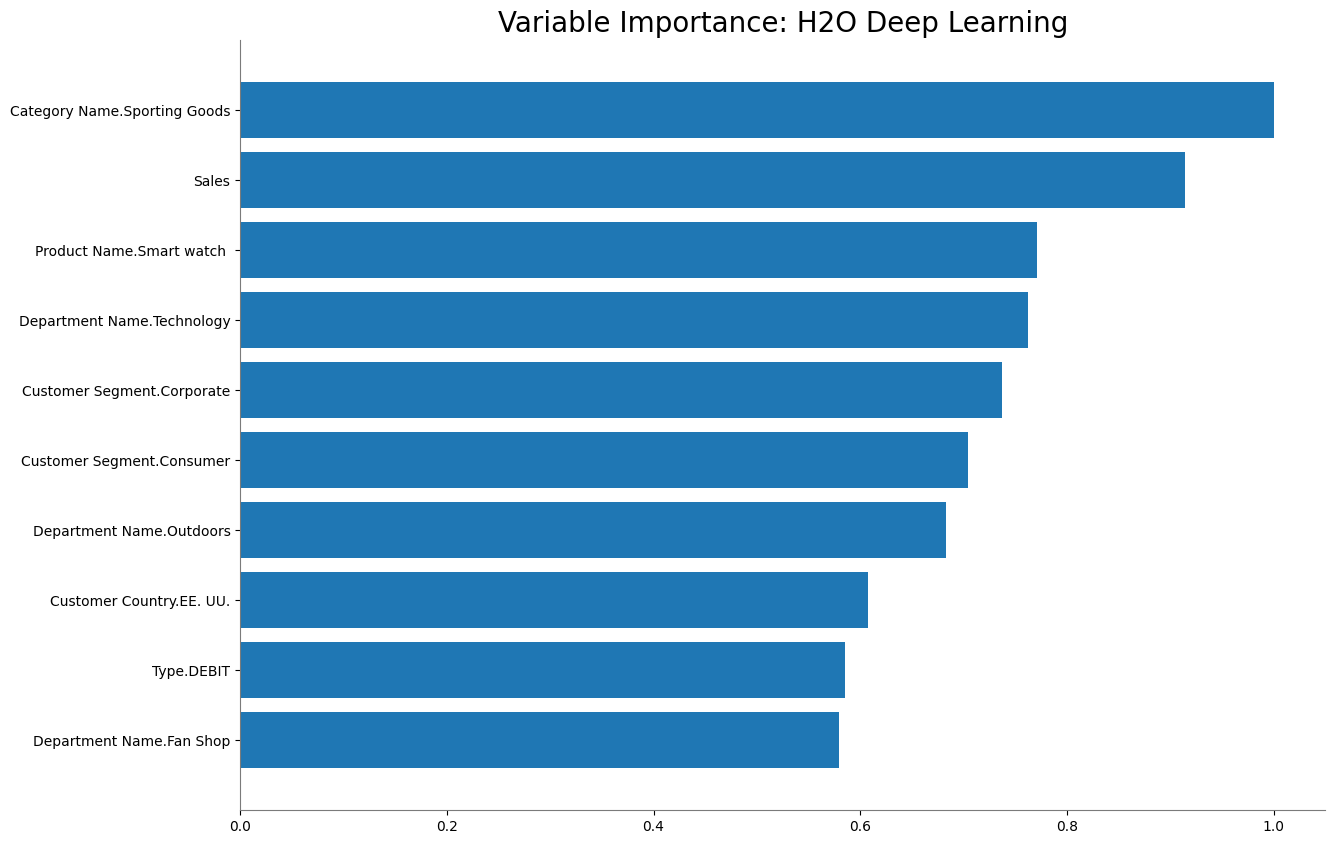

c:\Users\TYS\AppData\Local\Programs\Python\Python311\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


<Figure size 640x480 with 0 Axes>

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
import h2o
from h2o.automl import H2OAutoML
import mlflow
import mlflow.h2o

# Initialize H2O
h2o.init()

# Load data
df = load_csv("DataCo_cleaned.csv")

# H2O Frame
hf_dataset = h2o.H2OFrame(df)
train, test = hf_dataset.split_frame(ratios=[0.6], seed=1)
#test, val = test.split_frame(ratios=[0.5], seed=1)

# Define the target and features
y = "Order Item Quantity"
X = hf_dataset.columns
X.remove(y)

# Start MLflow experiment
with mlflow.start_run():
    # Configure and run H2O AutoML
    h2o_aml = H2OAutoML(max_models=12, seed=1, exclude_algos=["StackedEnsemble"], verbosity="info")
    h2o_aml.train(x=X, y=y, training_frame=train)

    # Log model
    mlflow.h2o.log_model(h2o_aml.leader, "model")

    # Now, save the model using the new function
    model_filename = "best_model_demand_forcasting"
    save_h2o_model(h2o_aml.leader, model_filename)

    # Logging parameters and metrics
    mlflow.log_params({
        "max_models": 12,
        "exclude_algos": "StackedEnsemble",
        "seed": 1
    })

    # Access performance metrics from the leaderboard
    perf = h2o_aml.leader.model_performance(test)
    mlflow.log_metrics({
        "rmse": perf.rmse(),
        "mae": perf.mae(),
        "r2": perf.r2()
    })

    # Variable importance plot
    h2o_aml.leader.varimp_plot()
    #save_fig(varimp_plot,"varimp_plot")
    # Log the leaderboard
    lb = h2o_aml.leaderboard.as_data_frame()
    lb.to_csv("leaderboard.csv", index=False)
    save_result(lb, "leaderboard.csv")
    mlflow.log_artifact("leaderboard.csv")

    # End run
    mlflow.end_run()
